<img src="https://github.com/seap-udea/xearch/blob/main/resources/xearch-logo.png?raw=true" align="left">

## Required packages

In [4]:
# External modules
import spiceypy as spy
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy.time import Time
import pandas as pd
import pickle
from datetime import datetime
from tqdm import tqdm
from IPython.display import display,HTML
import os
import rebound as rb

# Constants
G = c.G.value
Msun = c.M_sun.value
Mearth = c.M_earth.value
Mjup = c.M_jup.value
Rsun = c.R_sun.value
Rearth = c.R_earth.value
Rjup = c.R_jup.value
Mjup2earth = Mjup/Mearth
Rjup2earth = Rjup/Rearth

# Units
K = 1 # Kelvin
days = 86400
JD = days # Julian days
BJD = days # Bessel Julian days
years = 365.25*days # Julian years
au = c.au.value 
deg = np.pi/180
rad = 1/deg
Gyr = 1e9*years
dex = 1

# Useful routines
def sex2dec(angle):
    h, m, s = map(float, angle.split())
    sgn = np.sign(h)
    return sgn*(abs(h) + m/60 + s/3600)

def date2jd(date, format='%y/%m/%d'):
    dt = datetime.strptime(date, format)
    t = Time(dt)
    jd = t.jd
    return jd

def print_df(df):
    display(HTML(df.to_html()))

def filter(dataframe, conditions=[], dropna=None, show=0):
    cond = pd.Series([True]*len(dataframe))
    for condition in conditions:
        column = condition[0]
        value = condition[1]
        if isinstance(value,list):
            cond = (dataframe[column]>=value[0])&(dataframe[column]<=value[1])&cond
        else:
            cond_local = (dataframe[column] == value)
            if isinstance(value,str):
                cond_cont = (dataframe[column].str.contains(value))
                cond_local = cond_local|cond_cont
            cond = cond_local&cond
    
    data = dataframe[cond]
    if dropna is not None:
        data = data.dropna(subset=dropna)

    if show>0:
        print_df(data.head(show))

    return cond,data

class System(object):
    pass

def picklethis(data, filepath):
    if data is not None:
        with open(filepath, 'wb') as file:
            pickle.dump(data, file)

# Read database
suffix = 'eu' # Others: open, eu, nasa
exoplanets = pd.read_csv(f"exoplanets-{suffix}.csv")
systems = pickle.load(open(f"systems-{suffix}.pickle", 'rb'))

## Filter multiple systems

Filter systems where basic properties of their components are known:

All systems detected with RV:

In [16]:
cond,data = filter(exoplanets, [('method','RV'),('nplanets',[2,9])], show=0)
len(data)

539

Multiple systems with at least two planets:

In [203]:
cond,data = filter(exoplanets, [('method','RV'),('nplanets',[2,9])],dropna = ['a','period','mass'], show=0)
print(f"Number of potential systems: {len(data)}")
system_names = list(data.system_name.unique())
ndrop = 0
for system_name in tqdm(system_names):
    cond = data.system_name == system_name
    nplanets = cond.sum()
    if nplanets<2:
        # print(f"Dropping {system_name}")
        ndrop += 1
        nplanets = np.nan
    data.loc[cond,'nplanets'] = nplanets
data.dropna(subset=['nplanets'],inplace=True)
data = data.reset_index()
print(f"Number of final systems: {len(data)}")

Number of potential systems: 491


100%|██████████| 236/236 [00:00<00:00, 4290.40it/s]

Number of final systems: 426


In [38]:
print_df(data.head(10))

,index,system_name,declination,rightascension,distance,star_name,star_mass,star_radius,star_temperature,star_age,metallicity,spectraltype,magB,magV,magI,magR,magJ,magH,magK,planet_name,method,istransiting,dicovery,update,mass,radius,temperature,age,b,separation,a,e,I,w,W,M,L,period,et,tt,tp,tk,so,nplanets
0,14,24 Sex,0.000000,10.391214,72.2084,24 Sex,1.540,4.90,5098.0,NaN,NaN,G5,NaN,7.38,NaN,NaN,NaN,NaN,NaN,24 Sex b,RV,NaN,2010.0,21/10/02,584.804268,NaN,NaN,NaN,NaN,NaN,1.333000,0.0900,NaN,9.2,NaN,NaN,NaN,452.800000,NaN,NaN,NaN,NaN,NaN,2.0
1,15,24 Sex,0.000000,10.391214,72.2084,24 Sex,1.540,4.90,5098.0,NaN,NaN,G5,NaN,7.38,NaN,NaN,NaN,NaN,NaN,24 Sex c,RV,NaN,2010.0,21/10/02,483.099178,NaN,NaN,NaN,NaN,NaN,2.080000,0.2900,NaN,220.5,NaN,NaN,NaN,883.000000,NaN,NaN,NaN,NaN,NaN,2.0
2,128,47 Uma,40.429444,10.991389,13.9700,47 Uma,1.030,1.24,5892.0,NaN,NaN,G0V,NaN,5.10,NaN,NaN,NaN,NaN,NaN,47 Uma b,RV,NaN,1996.0,14/08/27,804.105869,NaN,NaN,NaN,NaN,NaN,2.100000,0.0320,NaN,334.0,NaN,NaN,NaN,1078.000000,NaN,NaN,NaN,NaN,NaN,3.0
3,129,47 Uma,40.429444,10.991389,13.9700,47 Uma,1.030,1.24,5892.0,NaN,NaN,G0V,NaN,5.10,NaN,NaN,NaN,NaN,NaN,47 Uma c,RV,NaN,2001.0,14/08/27,171.627340,NaN,NaN,NaN,NaN,NaN,3.600000,0.0980,NaN,295.0,NaN,NaN,NaN,2391.000000,NaN,NaN,NaN,NaN,NaN,3.0
4,130,47 Uma,40.429444,10.991389,13.9700,47 Uma,1.030,1.24,5892.0,NaN,NaN,G0V,NaN,5.10,NaN,NaN,NaN,NaN,NaN,47 Uma d,RV,NaN,2010.0,14/08/27,521.238587,NaN,NaN,NaN,NaN,NaN,11.600000,0.1600,NaN,110.0,NaN,NaN,NaN,14002.000000,NaN,NaN,NaN,NaN,NaN,3.0
5,134,55 Cnc,28.333889,8.876944,12.3400,55 Cnc,1.015,0.98,5196.0,NaN,NaN,K0IV-V,NaN,5.95,NaN,NaN,NaN,NaN,NaN,55 Cnc b,RV,NaN,1996.0,17/06/11,266.975862,NaN,NaN,NaN,NaN,NaN,0.113390,0.0023,89.73,110.0,NaN,NaN,NaN,14.653140,NaN,NaN,NaN,NaN,NaN,5.0
6,135,55 Cnc,28.333889,8.876944,12.3400,55 Cnc,1.015,0.98,5196.0,NaN,NaN,K0IV-V,NaN,5.95,NaN,NaN,NaN,NaN,NaN,55 Cnc c,RV,NaN,2002.0,17/06/11,56.700588,NaN,NaN,NaN,NaN,NaN,0.237350,0.0720,NaN,356.0,NaN,NaN,NaN,44.373000,NaN,NaN,NaN,NaN,NaN,5.0
7,136,55 Cnc,28.333889,8.876944,12.3400,55 Cnc,1.015,0.98,5196.0,NaN,NaN,K0IV-V,NaN,5.95,NaN,NaN,NaN,NaN,NaN,55 Cnc d,RV,NaN,2002.0,22/10/13,1220.461081,NaN,NaN,NaN,NaN,NaN,5.446000,0.0269,NaN,254.0,NaN,NaN,NaN,5574.200000,NaN,NaN,NaN,NaN,NaN,5.0
8,137,55 Cnc,28.333889,8.876944,12.3400,55 Cnc,1.015,0.98,5196.0,NaN,NaN,K0IV-V,NaN,5.95,NaN,NaN,NaN,NaN,NaN,55 Cnc e,RV,1.0,2004.0,24/01/27,8.590902,1.947,NaN,NaN,NaN,NaN,0.015439,0.0280,90.36,170.0,NaN,NaN,NaN,0.736548,NaN,NaN,NaN,NaN,NaN,5.0
9,138,55 Cnc,28.333889,8.876944,12.3400,55 Cnc,1.015,0.98,5196.0,NaN,NaN,K0IV-V,NaN,5.95,NaN,NaN,NaN,NaN,NaN,55 Cnc f,RV,NaN,2007.0,17/06/11,47.006821,NaN,NaN,NaN,NaN,NaN,0.773300,0.0800,NaN,139.0,NaN,NaN,NaN,260.910000,NaN,NaN,NaN,NaN,NaN,5.0


In [278]:
# https://www.researchgate.net/figure/Radial-velocity-time-series-of-the-Ups-And-system-spanning-almost-20-years-The-solid_fig2_253789798
# cond,data_filtered = filter(data, [('system_name','200964')], show=10)
#cond,data_filtered = filter(data, [('system_name','24 Sex')], show=10)
#cond,data_filtered = filter(data, [('system_name','55 Cnc')], show=10)
#cond,data_filtered = filter(data, [('system_name','82943')], show=10)
#cond,data_filtered = filter(data, [('system_name','114783')], show=10)
#cond,data_filtered = filter(data, [('system_name','ups And')], show=10)
#cond,data_filtered = filter(data, [('system_name','24040')], show=10)
#cond,data_filtered = filter(data, [('system_name','66428')], show=10)
#cond,data_filtered = filter(data, [('system_name','136925')], show=10)
#cond,data_filtered = filter(data, [('system_name','145675')], show=10)
#cond,data_filtered = filter(data, [('system_name','164922')], show=10)
#cond,data_filtered = filter(data, [('system_name','Sun')], show=10)
cond,data_filtered = filter(data, [('system_name','34445')], show=10)
#data = exoplanets; cond,data_filtered = filter(data, [('system_name','51 Peg')], show=10)
#data = exoplanets; cond,data_filtered = filter(data, [('system_name','Proxima')], show=10)
#data = exoplanets; cond,data_filtered = filter(data, [('system_name','14 Her')], show=10)

,system_name,declination,rightascension,distance,star_name,star_mass,star_radius,star_temperature,star_age,metallicity,spectraltype,magB,magV,magI,magR,magJ,magH,magK,planet_name,method,istransiting,dicovery,update,mass,radius,temperature,age,b,separation,a,e,I,w,W,M,L,period,et,tt,tp,tk,so,nplanets
1177,HD 34445,7.353333,5.294722,46.5,HD 34445,1.07,1.38,5836.0,NaN,NaN,G0V,NaN,7.31,NaN,NaN,NaN,NaN,NaN,HD 34445 b,RV,NaN,2004.0,17/11/06,199.914068,NaN,NaN,NaN,NaN,NaN,2.0750,0.014,NaN,115.0,NaN,NaN,NaN,1056.700,NaN,NaN,NaN,NaN,NaN,6
1178,HD 34445,7.353333,5.294722,46.5,HD 34445,1.07,1.38,5836.0,NaN,NaN,G0V,NaN,7.31,NaN,NaN,NaN,NaN,NaN,HD 34445 c,RV,NaN,2017.0,17/11/06,53.395172,NaN,NaN,NaN,NaN,NaN,0.7181,0.036,NaN,149.0,NaN,NaN,NaN,214.670,NaN,NaN,NaN,NaN,NaN,6
1179,HD 34445,7.353333,5.294722,46.5,HD 34445,1.07,1.38,5836.0,NaN,NaN,G0V,NaN,7.31,NaN,NaN,NaN,NaN,NaN,HD 34445 d,RV,NaN,2017.0,17/11/06,30.829355,NaN,NaN,NaN,NaN,NaN,0.4817,0.027,NaN,246.0,NaN,NaN,NaN,117.870,NaN,NaN,NaN,NaN,NaN,6
1180,HD 34445,7.353333,5.294722,46.5,HD 34445,1.07,1.38,5836.0,NaN,NaN,G0V,NaN,7.31,NaN,NaN,NaN,NaN,NaN,HD 34445 e,RV,NaN,2017.0,17/11/06,16.813123,NaN,NaN,NaN,NaN,NaN,0.2687,0.090,NaN,304.0,NaN,NaN,NaN,49.175,NaN,NaN,NaN,NaN,NaN,6
1181,HD 34445,7.353333,5.294722,46.5,HD 34445,1.07,1.38,5836.0,NaN,NaN,G0V,NaN,7.31,NaN,NaN,NaN,NaN,NaN,HD 34445 f,RV,NaN,2017.0,17/11/06,37.821580,NaN,NaN,NaN,NaN,NaN,1.5430,0.031,NaN,212.0,NaN,NaN,NaN,676.800,NaN,NaN,NaN,NaN,NaN,6
1182,HD 34445,7.353333,5.294722,46.5,HD 34445,1.07,1.38,5836.0,NaN,NaN,G0V,NaN,7.31,NaN,NaN,NaN,NaN,NaN,HD 34445 g,RV,NaN,2017.0,17/11/06,120.774795,NaN,NaN,NaN,NaN,NaN,6.3600,0.032,NaN,235.0,NaN,NaN,NaN,5700.000,NaN,NaN,NaN,NaN,NaN,6


In [293]:
# Create system
system = System()
system.name = data_filtered.system_name.iloc[0]
system.data = data[data['system_name'] == system.name]
system.mstar = system.data.star_mass.iloc[0]
code_name = system.name.replace(' ','_').replace('.','_')
code_name

'HD_34445'

In [320]:
# Canonical units
system.UM = Msun
system.UL = au
system.UT = years
system.UV = system.UL/system.UT

# Rebound
sim = rb.Simulation()
sim.units = 'yr', 'au', 'msun'

# Add star
np.random.seed(1)
sim.add(m=system.mstar)

# Add planets
system.planets = []
system.Ks = []
for plindex in system.data.index:
    pl = system.data.loc[plindex]
    system.planets += [dict(
        m = pl.mass*Mearth/system.UM,
        a = pl.a*au/system.UL,
        e = pl.e, 
        inc = 90.0*deg if pd.isna(pl.I) else pl.I*deg,
        Omega = np.random.uniform(0,360)*deg if pd.isna(pl.W) else pl.W*deg,
        omega = np.random.uniform(0,360)*deg if pd.isna(pl.w) else pl.w*deg,
        M = np.random.uniform(0,360)*deg if pd.isna(pl.M) else pl.M*deg,
    )]
    sim.add(**system.planets[-1])

    # Add period
    system.planets[-1]['Pdata'] = pl.period*days/system.UT   
    # Determine the Kmax for the planet
    system.planets[-1]['Kdata'] = 2*np.pi*pl.a*system.UL/(pl.period*days)*np.sin(system.planets[-1]['inc'])/np.sqrt(1-system.planets[-1]['e']**2)*pl.mass*Mearth/(system.mstar*system.UM)/system.UV   
    system.Ks += [system.planets[-1]['Kdata']]

system.imax = np.argmax(system.Ks)
system.Pmax = system.planets[system.imax]['Pdata']
print(f"Planet producing largest signal: {system.imax}")
print(f"Period of the planet producing the largest signal: {system.Pmax*system.UT/days}, Kmax = {system.Ks[system.imax]*system.UV}")
sim.move_to_com()
system.nplanets = len(system.planets)

# Integrate
system.nperiods = 6
system.fcadency = 1/200 # in periods
system.tobs = np.arange(0,system.nperiods*system.Pmax,system.fcadency*system.Pmax)
Nt = len(system.tobs)
system.Xs = np.zeros((Nt,6))
for i,t in enumerate(system.tobs):
    sim.integrate(t)
    #sim.move_to_com()
    system.Xs[i] = sim.particles[0].xyz + sim.particles[0].vxyz

system.vrads = system.Xs[:,5]
system.Kmax = (system.vrads.max()-system.vrads.min())/2
system.vrads.max()*system.UV, system.Kmax*system.UV

Planet producing largest signal: 0
Period of the planet producing the largest signal: 1056.7, Kmax = 11.989088639856611


(26.669035321461227, 25.66558473210817)

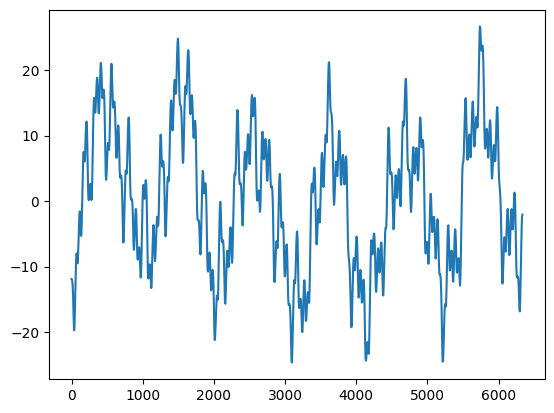

In [321]:
plt.plot(system.tobs*system.UT/days,system.vrads*system.UV)

In [322]:
system.data.star_mass

1177    1.07
1178    1.07
1179    1.07
1180    1.07
1181    1.07
1182    1.07
Name: star_mass, dtype: float64

In [333]:
', '.join([str(K) for K in np.around(np.array(system.Ks)*system.UV,1)])

'12.0, 5.5, 3.8, 2.8, 2.6, 4.1'

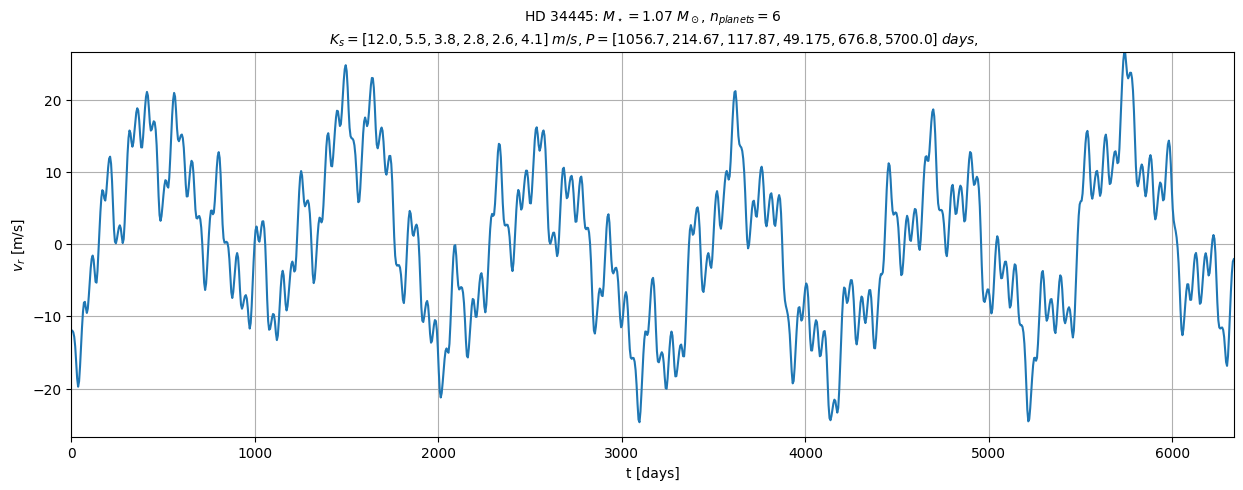

In [341]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(system.tobs*system.UT/days,system.vrads*system.UV)
ax.grid()
ax.set_ylabel(r'$v_r$ [m/s]')
ax.set_xlabel('t [days]')
ax.set_title(f"{system.name}: \
$M_\star = {system.mstar:.2f}\;M_\odot$, \
$n_{{planets}} = {system.nplanets}$\n \
$K_{{s}} = [{', '.join([str(K) for K in np.around(np.array(system.Ks)*system.UV,1)])}]\;m/s$, \
$P = [{', '.join([str(pl['Pdata']*system.UT/days) for pl in system.planets])}]\;days$, \
",
fontsize=10
)
Krange = max(abs(system.vrads).max(),abs(system.vrads).min())*system.UV
ax.set_ylim(-Krange,Krange)
ax.set_xlim(0,system.tobs.max()*system.UT/days)

# Save figure
fig.savefig(f"figs/rv/fig_{code_name}",bbox_inches='tight')

In [317]:
picklethis(system,f"signals/rv/{code_name}.pkl")

Let's compile all:

In [355]:
data

TypeError: concat() got an unexpected keyword argument 'reset_index'

In [357]:
cond,data = filter(exoplanets, [('method','RV')], dropna = ['star_mass','a','period','mass'], show=10)
data = pd.concat([data,exoplanets[exoplanets.system_name == 'Sun']])

print(f"Number of potential planets: {len(data)}")
system_names = list(data.system_name.unique())
print(f"Number of final systems: {len(system_names)}")

,system_name,declination,rightascension,distance,star_name,star_mass,star_radius,star_temperature,star_age,metallicity,spectraltype,magB,magV,magI,magR,magJ,magH,magK,planet_name,method,istransiting,dicovery,update,mass,radius,temperature,age,b,separation,a,e,I,w,W,M,L,period,et,tt,tp,tk,so,nplanets
0,11 Com,17.792778,12.345278,110.6000,11 Com,2.70,19.000,4742.0,NaN,NaN,G8III,NaN,4.74,NaN,NaN,NaN,NaN,NaN,11 Com b,RV,NaN,2007.0,23/03/03,5126.063673,NaN,NaN,NaN,NaN,NaN,1.290,0.231,NaN,94.80,NaN,NaN,NaN,326.0300,NaN,NaN,NaN,NaN,NaN,1
2,11 UMi,71.823889,15.285000,119.5000,11 UMi,1.80,24.080,4340.0,NaN,NaN,K4III,NaN,5.02,NaN,NaN,NaN,NaN,NaN,11 UMi b,RV,NaN,2009.0,23/03/03,3523.858892,NaN,NaN,NaN,NaN,NaN,1.540,0.080,NaN,117.63,NaN,NaN,NaN,516.2200,NaN,NaN,NaN,NaN,NaN,1
3,14 And,39.236111,23.521389,76.4000,14 And,2.20,11.000,4813.0,NaN,NaN,K0III,NaN,5.22,4.1,NaN,3.02,2.61,2.33,14 And b,RV,NaN,2008.0,23/03/03,1488.708256,NaN,NaN,NaN,NaN,NaN,0.830,0.000,NaN,NaN,NaN,NaN,NaN,185.8400,NaN,NaN,NaN,NaN,NaN,1
5,14 Her,43.821667,16.173056,18.1000,14 Her,0.90,0.708,5311.0,NaN,NaN,K0V,NaN,6.67,NaN,NaN,NaN,NaN,NaN,14 Her c,RV,NaN,2006.0,23/05/22,2256.581687,NaN,NaN,NaN,NaN,NaN,27.000,0.650,82.0,0.01,NaN,NaN,NaN,52160.0000,NaN,NaN,NaN,NaN,NaN,2
6,16 Cyg B,50.517500,19.697500,21.4100,16 Cyg B,1.01,0.980,5766.0,NaN,NaN,G2.5V,NaN,6.20,NaN,NaN,NaN,NaN,NaN,16 Cyg B b,RV,NaN,1996.0,21/10/02,521.238587,NaN,NaN,NaN,NaN,NaN,1.680,0.689,NaN,83.40,NaN,NaN,NaN,799.5000,NaN,NaN,NaN,NaN,NaN,1
7,17 Sco,-11.837778,16.230833,116.0000,17 Sco,1.22,25.920,4157.0,NaN,NaN,K3III,NaN,5.24,NaN,NaN,NaN,NaN,NaN,17 Sco b,RV,NaN,2020.0,20/10/26,1373.018716,NaN,NaN,NaN,NaN,NaN,1.450,0.060,NaN,57.03,NaN,NaN,NaN,578.3800,NaN,NaN,NaN,NaN,NaN,1
8,18 Del,10.839167,20.973889,73.1000,18 Del,2.30,8.500,4979.0,NaN,NaN,G6III,NaN,5.52,NaN,NaN,4.03,3.44,3.67,18 Del b,RV,NaN,2008.0,21/10/02,3273.632588,NaN,NaN,NaN,NaN,NaN,2.600,0.080,NaN,166.10,NaN,NaN,NaN,993.3000,NaN,NaN,NaN,NaN,NaN,1
13,24 Boo,49.845000,14.477500,100.0000,24 Boo,0.99,10.640,4893.0,NaN,NaN,G3IV,NaN,5.60,NaN,NaN,NaN,NaN,NaN,24 Boo b,RV,NaN,2018.0,23/08/07,289.223850,NaN,NaN,NaN,NaN,NaN,0.190,0.042,NaN,210.00,NaN,NaN,NaN,30.3506,NaN,NaN,NaN,NaN,NaN,1
14,24 Sex,0.000000,10.391214,72.2084,24 Sex,1.54,4.900,5098.0,NaN,NaN,G5,NaN,7.38,NaN,NaN,NaN,NaN,NaN,24 Sex b,RV,NaN,2010.0,21/10/02,584.804268,NaN,NaN,NaN,NaN,NaN,1.333,0.090,NaN,9.20,NaN,NaN,NaN,452.8000,NaN,NaN,NaN,NaN,NaN,2
15,24 Sex,0.000000,10.391214,72.2084,24 Sex,1.54,4.900,5098.0,NaN,NaN,G5,NaN,7.38,NaN,NaN,NaN,NaN,NaN,24 Sex c,RV,NaN,2010.0,21/10/02,483.099178,NaN,NaN,NaN,NaN,NaN,2.080,0.290,NaN,220.50,NaN,NaN,NaN,883.0000,NaN,NaN,NaN,NaN,NaN,2


Number of potential planets: 940
Number of final systems: 705


In [374]:
plt.ioff()
plt.close('all')

nplanet = 0 
excluded = []
np.random.seed(1)
Force = True
for system_name in tqdm(system_names):

    # Read basic information
    system = System()
    system.name = system_name
    system.data = data[data['system_name'] == system.name]
    system.mstar = system.data.star_mass.iloc[0]
    code_name = system.name.replace(' ','_').replace('.','_')
    
    # Canonical units
    system.UM = Msun
    system.UL = au
    system.UT = years
    system.UV = system.UL/system.UT

    # Rebound
    sim = rb.Simulation()
    sim.units = 'yr', 'au', 'msun'

    # Add star
    np.random.seed(1)
    sim.add(m=system.mstar)

    # Add planets
    system.planets = []
    system.Ks = []
    system.Ps = []
    for plindex in system.data.index:
        pl = system.data.loc[plindex]
        system.planets += [dict(
            m = pl.mass*Mearth/system.UM,
            a = pl.a*au/system.UL,
            e = pl.e, 
            inc = 90.0*deg if pd.isna(pl.I) else pl.I*deg,
            Omega = np.random.uniform(0,360)*deg if pd.isna(pl.W) else pl.W*deg,
            omega = np.random.uniform(0,360)*deg if pd.isna(pl.w) else pl.w*deg,
            M = np.random.uniform(0,360)*deg if pd.isna(pl.M) else pl.M*deg,
        )]
        sim.add(**system.planets[-1])

        # Add period
        system.planets[-1]['Pdata'] = pl.period*days/system.UT   
        # Determine the Kmax for the planet
        system.planets[-1]['Kdata'] = 2*np.pi*pl.a*system.UL/(pl.period*days)*np.sin(system.planets[-1]['inc'])/np.sqrt(1-system.planets[-1]['e']**2)*pl.mass*Mearth/(system.mstar*system.UM)/system.UV   
        system.Ks += [system.planets[-1]['Kdata']]
        system.Ps += [system.planets[-1]['Pdata']]

    system.nplanets = len(system.planets)

    # Maximum period criteria
    system.imax = np.argmax(system.Ks)
    """
    dKstd = np.std(system.Ks)/np.max(system.Ks)
    if dKstd<0.1:
        ## Taking the logarithmic average of all periods
        system.Pmax = np.exp(np.log(system.Ps).mean())
        system.Pmax_strategy = 'log'
    elif dKstd<0.5:
        ## Using the average of the period of the most perturbing planet and the farthest planet
        system.Pmax = (system.planets[system.imax]['Pdata'] + max(system.Ps))/2
        system.Pmax_strategy = 'avg'
    else:
        ## Using the period of the most perturbing planet
        system.Pmax = system.planets[system.imax]['Pdata']
        system.Pmax_strategy = 'max'
    """
    # Single strategy
    system.Pmax = system.planets[system.imax]['Pdata']
    system.Pmax_strategy = 'max'
    
    sim.move_to_com()

    # Observation parameters
    system.nperiods = 6
    system.fcadency = 1/200 # in periods
    system.tmin = 0
    system.tmax = system.nperiods*system.Pmax
    system.duration = system.tmax - system.tmin
    system.tobs = np.arange(system.tmin,system.tmax,system.fcadency*system.Pmax)
    Nt = len(system.tobs)
    
    # Generating signal
    system.Xs = np.zeros((Nt,6))
    for i,t in enumerate(system.tobs):
        sim.integrate(t)
        sim.move_to_com()
        system.Xs[i] = sim.particles[0].xyz + sim.particles[0].vxyz
    system.vrads = system.Xs[:,5]

    # Determine the Kmax for the planet
    system.Kmax = (system.vrads.max()-system.vrads.min())/2
    
    figpath = f"figs/rv/fig_{code_name}.png"
    syspath = f"signals/rv/{code_name}.pkl"

    if (os.path.exists(figpath) and os.path.exists(syspath)) and (not Force):
        nplanet += 1
        continue
    
    # Generating figure   
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(system.tobs*system.UT/days,system.vrads*system.UV)
    ax.grid()
    ax.set_ylabel(r'$v_r$ [m/s]')
    ax.set_xlabel('t [days]')
    ax.set_title(f"{system.name}: \
$M_\star = {system.mstar:.2f}\;M_\odot$, \
$n_{{planets}} = {system.nplanets}$\n \
$e = [{', '.join([str(np.round(pl['e'],3)) for pl in system.planets])}]$, \
$K_{{s}} = [{', '.join([str(K) for K in np.around(np.array(system.Ks)*system.UV,2)])}]\;m/s$, \
$P = [{', '.join([str(np.round(pl['Pdata']*system.UT/days,1)) for pl in system.planets])}]\;days$, \
Reference $P = {np.round(system.Pmax*system.UT/days,1)}\;days$ (strategy {system.Pmax_strategy}) \
",
    fontsize=8
    )

    Krange = max(abs(system.vrads).max(),abs(system.vrads).min())*system.UV
    try: 
        ax.set_ylim(-Krange,Krange)
    except:
        # Skipping system
        excluded += [(index,system.data.planet_name)]
        plt.close('all')
        continue
    ax.set_xlim(0,system.tobs.max()*system.UT/days)

    # Save figure
    fig.savefig(f"figs/rv/fig_{code_name}",bbox_inches='tight')

    # Save data
    picklethis(system,f"signals/rv/{code_name}.pkl")

    """
    print(system.name,system.nplanets); 
    if nplanet>10:break
    # """;
    if nplanet>10 and False:
        break

    nplanet += 1
    plt.close('all')

plt.ion()

  6%|▌         | 44/705 [00:14<02:36,  4.23it/s]/home/jzuluaga/.local/lib/python3.10/site-packages/rebound/simulation.py:254: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)
100%|██████████| 705/705 [02:31<00:00,  4.66it/s]


In [366]:
len(excluded)

31